# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда.



In [2]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3,
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader


In [3]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64,
                                                         transform_train=transform)

100%|██████████| 170498071/170498071 [00:12<00:00, 13566641.07it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Посмотрим на изображения:

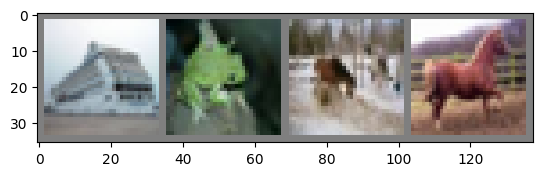

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [5]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Базовый блок модели
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32)
        )
        # Блок с пулингом
        self.pooling_block = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(12, 6)
        )
        # Отдельная свертка на прокид старых градиентов
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1)
        # Классификатор
        self.classifier = nn.Linear(in_features=512, out_features=n_classes)

    def forward(self, x):
        conv_output = self.conv_1(x)
        feature_map = self.conv_block(x)
        feature_map+=conv_output
        pooling = self.pooling_block(feature_map)
        flat = torch.flatten(pooling, start_dim=1)
        out = self.classifier(flat)
        return out

In [6]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv_block): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pooling_block): Sequential(
    (0): ReLU()
    (1): AvgPool2d(kernel_size=12, stride=6, padding=0)
  )
  (conv_1): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (classifier): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [7]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [12]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    for data, target in loader:
        # Классическая работа с тестом модели
        data = data.to(device)

        target = target.to(device)

        logits = model(data)

        loss = F.cross_entropy(logits, target)

        loss_log.append(loss.item())

        acc = (logits.argmax(dim=1) == target).sum() / logits.shape[0]

        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:
        # Классическое обучение модели, оно почти всегда одинаково
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()

        logits = model(data)

        loss = F.cross_entropy(logits, target)

        loss.backward()

        optimizer.step()

        loss_log.append(loss.item())
        # Считаем accuracy по батчу
        acc = (logits.argmax(dim=1) == target).sum() / logits.shape[0]

        acc_log.append(acc.item())

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.5242924204256243, train acc: 0.45497355709564097
 val loss: 1.4045334506542124, val acc: 0.5015957446808511

Epoch 1
 train loss: 1.2168209880753889, train acc: 0.5751909768341664
 val loss: 1.1968613515508937, val acc: 0.5817154255319149

Epoch 2
 train loss: 1.0922910401110675, train acc: 0.618952402793947
 val loss: 1.0487792912949907, val acc: 0.6354388297872341

Epoch 3
 train loss: 1.0263214871913904, train acc: 0.6431591146824782
 val loss: 1.0125710332647282, val acc: 0.6564051420130628

Epoch 4
 train loss: 0.9869257639923305, train acc: 0.6568988313186757
 val loss: 0.9814073641249474, val acc: 0.6626994680851064

Epoch 5
 train loss: 0.9441776886936516, train acc: 0.6760413946355719
 val loss: 0.9609764050930104, val acc: 0.6673980497299357

Epoch 6
 train loss: 0.9241868965804468, train acc: 0.6798078806788219
 val loss: 0.9441516379092602, val acc: 0.6753102837724888

Epoch 7
 train loss: 0.8979601623589204, train acc: 0.6888874380200611
 val loss: 0

Посчитайте точность на тестовой выборке:

In [ ]:
# Считаем тест
loss_log, acc_log = test(net, test_loader)
loss_log, acc_log

(0.8476887926174577, 0.7146695859872612)

# Accuracy получилась 71% на тестовой

Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

In [9]:
# Данный код взят из семинара по dl у продвинутой группы

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

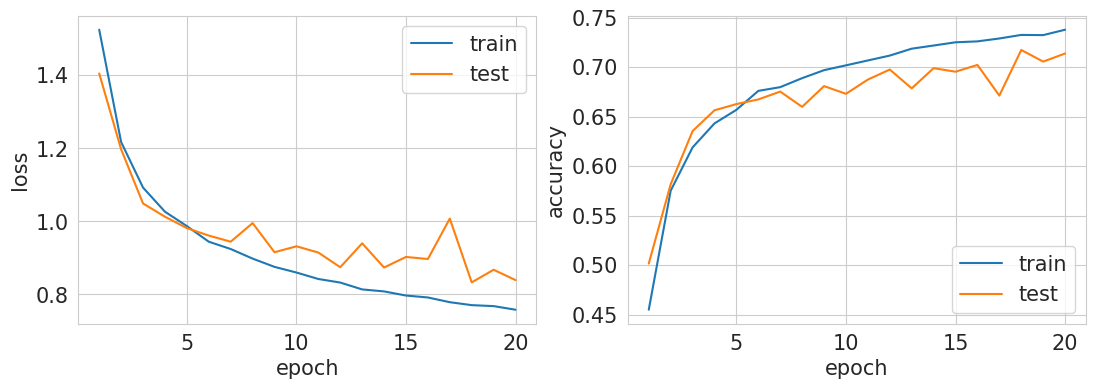

In [ ]:
#  Считаю количество бачей в одной эпохе
skip_size = int(len(train_loss_log) / 20)
#  Чтобы честно посчитать обучающий лосс и точность усредняю лоссы и точности по эпохам
#  ПРеобразую массив в нумпаевский массив и делаю решейп чтобы группировать элементы по skip_size (по 547 элементов в эпоху)
train_skip_loss = np.asarray(train_loss_log).reshape(-1, skip_size).mean(axis=1)
train_skip_accuracy = np.asarray(train_acc_log).reshape(-1, skip_size).mean(axis=1)

plot_losses(train_skip_loss, val_loss_log, train_skip_accuracy, val_acc_log)

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4708442405765192, train acc: 0.47430791333998795
 val loss: 1.257772068267173, val acc: 0.5557624114320633

Epoch 1
 train loss: 1.1683921590583635, train acc: 0.5903058893283935
 val loss: 1.1067726442154417, val acc: 0.6182624114320633

Epoch 2
 train loss: 1.06038768156355, train acc: 0.6344713045648509
 val loss: 1.085573505848012, val acc: 0.6264184397585848

Epoch 3
 train loss: 1.0030565606174784, train acc: 0.6530752154765225
 val loss: 1.0018424467837557, val acc: 0.6507978723404255

Epoch 4
 train loss: 0.9683677315494043, train acc: 0.6628933795191471
 val loss: 0.9717195751819204, val acc: 0.6692597518575952

Epoch 5
 train loss: 0.9396720988440993, train acc: 0.6726136067013854
 val loss: 1.0255708793376355, val acc: 0.6497783688788719

Epoch 6
 train loss: 0.9101861148146432, train acc: 0.6846883978006827
 val loss: 0.9686667520949181, val acc: 0.6645390071767442

Epoch 7
 train loss: 0.8942978765672478, train acc: 0.6904911530737031
 val loss: 0.96

Посчитайте точность на тестовой выборке:

In [ ]:
loss_log, acc_log = test(net, test_loader)
loss_log, acc_log

(0.8048488678066594, 0.7221337579617835)

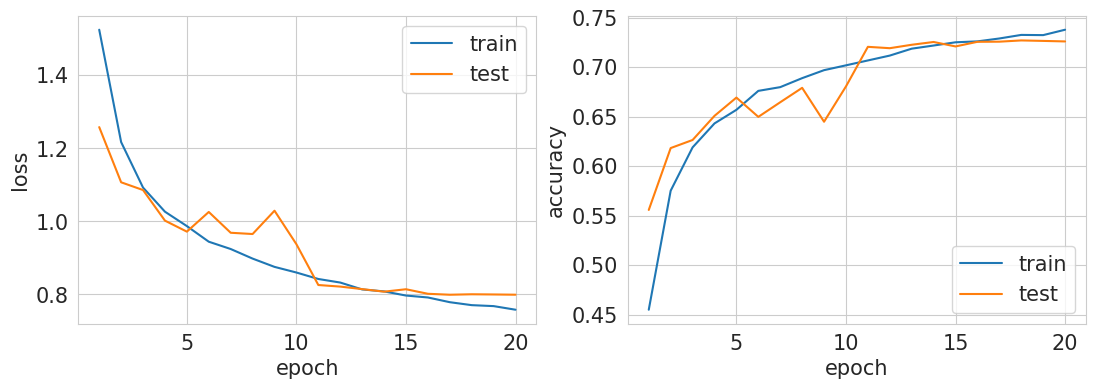

In [ ]:
skip_size = int(len(train_loss_log) / 20)
#  Чтобы честно посчитать обучающий лосс и точность усредняю лоссы и точности по эпохам
#  ПРеобразую массив в нумпаевский массив и делаю решейп чтобы группировать элементы по skip_size (по 547 элементов в эпоху)
train_skip_loss = np.asarray(train_loss_log).reshape(-1, skip_size).mean(axis=1)
train_skip_accuracy = np.asarray(train_acc_log).reshape(-1, skip_size).mean(axis=1)

plot_losses(train_skip_loss, val_loss_log, train_skip_accuracy, val_acc_log)

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.8310784574400572, train acc: 0.3545638548390739
 val loss: 1.6046280876119086, val acc: 0.43045212765957447

Epoch 1
 train loss: 1.5282654690350213, train acc: 0.4567568230236688
 val loss: 1.4463038921356202, val acc: 0.4797207446808511

Epoch 2
 train loss: 1.4256570524445835, train acc: 0.49150806349417847
 val loss: 1.4448196456787434, val acc: 0.47819148936170214

Epoch 3
 train loss: 1.363210798181607, train acc: 0.5189222055989602
 val loss: 1.3451874859789585, val acc: 0.5248448582405739

Epoch 4
 train loss: 1.3120702719775588, train acc: 0.5346451423503799
 val loss: 1.276243876903615, val acc: 0.5520611702127659

Epoch 5
 train loss: 1.2640408784205561, train acc: 0.5544120527708553
 val loss: 1.249450724936546, val acc: 0.5633865248649679

Epoch 6
 train loss: 1.2174725855072412, train acc: 0.5728853813473006
 val loss: 1.2066391736903088, val acc: 0.5778147163543296

Epoch 7
 train loss: 1.1842210958601134, train acc: 0.5850458671449525
 val loss: 1

# Видно что качество стало намного хуже, на целых 6% на валидационной выборке

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, last_epoch=-1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.5275623615306735, train acc: 0.4539003330785134
 val loss: 1.3326089914808883, val acc: 0.5275044327086591

Epoch 1
 train loss: 1.2073852231341262, train acc: 0.5741136720237174
 val loss: 1.1646360209647646, val acc: 0.5939273050490846

Epoch 2
 train loss: 1.089852541848554, train acc: 0.6207315879286535
 val loss: 1.12345030764316, val acc: 0.608843085106383

Epoch 3
 train loss: 1.018856568027022, train acc: 0.6456116153509569
 val loss: 1.0191152915041497, val acc: 0.6477171986661059

Epoch 4
 train loss: 0.9708839507817786, train acc: 0.6625220358262768
 val loss: 0.9799289188486464, val acc: 0.6570921986661059

Epoch 5
 train loss: 0.9404874518105055, train acc: 0.6749396057189927
 val loss: 1.024170766739135, val acc: 0.6520833335024245

Epoch 6
 train loss: 0.9142316064407446, train acc: 0.6844394750743287
 val loss: 0.9720837045223155, val acc: 0.660815602921425

Epoch 7
 train loss: 0.8853758024341227, train acc: 0.6943066075471463
 val loss: 0.922282

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4977602434550605, train acc: 0.4683174458238717
 val loss: 1.3338945094575274, val acc: 0.5314494680851064

Epoch 1
 train loss: 1.1888201064557873, train acc: 0.5856375685557587
 val loss: 1.1791477188150934, val acc: 0.601063829787234

Epoch 2
 train loss: 1.0835293168559588, train acc: 0.6247061896367744
 val loss: 1.0336588915358198, val acc: 0.6426640071767442

Epoch 3
 train loss: 1.0234347673395217, train acc: 0.6435427005373799
 val loss: 1.0328148329511602, val acc: 0.6464317377577437

Epoch 4
 train loss: 0.983477040880123, train acc: 0.6582781078610603
 val loss: 0.9819334446115696, val acc: 0.6668882978723404

Epoch 5
 train loss: 0.9502260196797373, train acc: 0.6702100744630999
 val loss: 0.9682738276238138, val acc: 0.6701462765957447

Epoch 6
 train loss: 0.917564378142139, train acc: 0.6822848655623971
 val loss: 0.9585867904602213, val acc: 0.6700132978723404

Epoch 7
 train loss: 0.898326343984447, train acc: 0.6877815683101606
 val loss: 1.035

# Выводы:
> 1. При использовании экспоненциального изменения lr мы достигаем результатов, сопоставимых с MultiStep scheduler. Если поизменять и подобрать грамотный lr и грамотное gamma, можно добиться хороших результатов.
Данный scheduler изменяет lr по экспоненте:
$$
lr_{new} = lr_{old}^{gamma}
$$
> 2. Изменение lr методом косинусоного отжига показало результаты лучше, чем наш бейзлайн с scheduler
Данный scheduler использует формулу косинусного обжига внутри:
$$
η_t = η_{min} + \frac{1}{2}*(η_{max} - η_{min})*(1 + \cos(\frac{T_{cur}}{T_{max}} * π))
$$

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

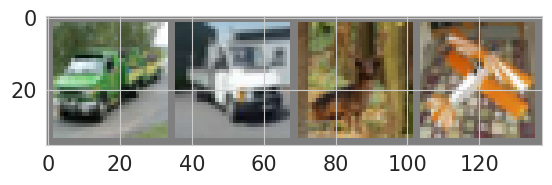

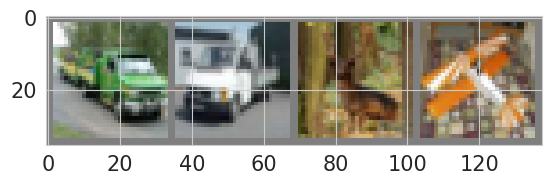

In [10]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [13]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4988964337317556, train acc: 0.46300029384152763
 val loss: 1.2408282589405142, val acc: 0.5599512412192974

Epoch 1
 train loss: 1.1672688540636513, train acc: 0.592407449725777
 val loss: 1.1149138564759113, val acc: 0.6143617021276596

Epoch 2
 train loss: 1.0602942731306366, train acc: 0.6304436537421818
 val loss: 1.0091118845533817, val acc: 0.6573138297872341

Epoch 3
 train loss: 1.0148449208880255, train acc: 0.6497739293021737
 val loss: 0.9944011842950862, val acc: 0.6574024823117763

Epoch 4
 train loss: 0.9739019398933355, train acc: 0.6609632084095064
 val loss: 1.026145239332889, val acc: 0.646187943346957

Epoch 5
 train loss: 0.9509497064777005, train acc: 0.6726462522851919
 val loss: 0.9659860750462147, val acc: 0.6652482271194458

Epoch 6
 train loss: 0.930634792369724, train acc: 0.6785632672649851
 val loss: 0.9388938277325731, val acc: 0.6763741135597229

Epoch 7
 t

Посчитайте точность на тестовой выборке:

In [ ]:
loss_log, acc_log = test(net, test_loader)
loss_log, acc_log

(0.7882424657511863, 0.732484076433121)

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [ ]:
transform = transforms.Compose(
        [transforms.ColorJitter(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.5052863448803777, train acc: 0.46058451955017704
 val loss: 1.2728043748977336, val acc: 0.5487367021276596

Epoch 1
 train loss: 1.1913380628312091, train acc: 0.5822342648366687
 val loss: 1.126155790876835, val acc: 0.6055186170212766

Epoch 2
 train loss: 1.0535268189702216, train acc: 0.6346549360146252
 val loss: 1.0379536425813716, val acc: 0.6459884752618505

Epoch 3
 train loss: 0.9956498448983843, train acc: 0.657845553684932
 val loss: 1.0403143504832653, val acc: 0.6478501773895101

Epoch 4
 train loss: 0.9542871907598576, train acc: 0.668985864471038
 val loss: 0.9803426496526029, val acc: 0.6668661348363186

Epoch 5
 train loss: 0.9247948933780956, train acc: 0.6790121441785335
 val loss: 0.9415404119390123, val acc: 0.6721852837724889

Epoch 6
 train loss: 0.900103830332294, train acc: 0.6889364064502542
 val loss: 0.9325931381671987, val acc: 0.6798093973322118

Epoch 7
 t

In [ ]:
transform = transforms.Compose(
        [transforms.RandomRotation([-20, 20]),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.5578206638095584, train acc: 0.440421781221735
 val loss: 1.3628128893831943, val acc: 0.5127437944107868

Epoch 1
 train loss: 1.3136728630423329, train acc: 0.5328781992687386
 val loss: 1.234466571757134, val acc: 0.5619902482692232

Epoch 2
 train loss: 1.196931722395163, train acc: 0.5750563137056187
 val loss: 1.1578149605304637, val acc: 0.6004432624958931

Epoch 3
 train loss: 1.1342998751774567, train acc: 0.6012911334552102
 val loss: 1.1226093094399634, val acc: 0.6083333333756061

Epoch 4
 train loss: 1.086503388785793, train acc: 0.6200868372943327
 val loss: 1.1302273636168623, val acc: 0.6105053191489361

Epoch 5
 train loss: 1.0487197390204155, train acc: 0.6345569992632055
 val loss: 1.1127875848019377, val acc: 0.6086436170212766

Epoch 6
 train loss: 1.0264146630899127, train acc: 0.6405229825642252
 val loss: 1.0566490584231438, val acc: 0.6338209220703612

Epoch 7
 tr

In [ ]:
#  Совместный
transform = transforms.Compose(
        [transforms.ColorJitter(),
         transforms.RandomRotation([-20, 20]),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.563281850579452, train acc: 0.4367409898768395
 val loss: 1.3847727866882973, val acc: 0.5032801418862445

Epoch 1
 train loss: 1.311164121305267, train acc: 0.5351837947556044
 val loss: 1.2514888900391599, val acc: 0.5585549646235527

Epoch 2
 train loss: 1.2028862382855667, train acc: 0.5739830895795247
 val loss: 1.1442476868629456, val acc: 0.6035239361702127

Epoch 3
 train loss: 1.1406977884948144, train acc: 0.5998016779993744
 val loss: 1.1197221976645448, val acc: 0.6114804965384463

Epoch 4
 train loss: 1.0933359400445843, train acc: 0.6153409833010197
 val loss: 1.0995373416454235, val acc: 0.6210549646235527

Epoch 5
 train loss: 1.0655916529338145, train acc: 0.6293377840322811
 val loss: 1.0746749292028712, val acc: 0.6217641845662543

Epoch 6
 train loss: 1.0413160528953593, train acc: 0.6337898276623686
 val loss: 1.0538664193863565, val acc: 0.632690602921425

Epoch 7
 t

# Выводы
> Было решено попробовать 2 метода аугментации:
1. ColorJitter - произвольное изменение яркости, контрастности, насыщенности и оттенка изображения. Использование данной аугментации по результатам примерно эквивалентно результатам бэйслайна. 73% accuracy при данной аугментации, против 73% при аугментации - горизонтальном отображении
2. RandomRotation - вращение картинки на определенный градус. В примере была выбрана ротация от -20 до 20 градусов. Использование данной аугментации при обучении сильно снизило качество модели. 69% accuracy при использовании данной аугментации, против 73% при аугментации - горизонтальном отображении
3. Теперь попробуем эти 2 метода аугментации вместе: \
Как видно, лучше не стало. Ротация + изменение яркости изображения привело к качеству 69% accuracy на валидации, против 73% при горизонтальном отображении


## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [14]:
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.0 MB/s eta 0:00:00


In [15]:
import wandb

In [16]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Предупреждение:
## Далее я решил много поэкспериментировать и там куча разных моделей с разными lr
# P.S. Я же не зря купил колаб про

In [22]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    for data, target in loader:

        data = data.to(device)

        target = target.to(device)

        logits = model(data)

        loss = F.cross_entropy(logits, target)

        loss_log.append(loss.item())

        acc = (logits.argmax(dim=1) == target).sum() / logits.shape[0]

        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:

        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()

        logits = model(data)

        loss = F.cross_entropy(logits, target)

        loss.backward()

        optimizer.step()

        loss_log.append(loss.item())

        acc = (logits.argmax(dim=1) == target).sum() / logits.shape[0]

        acc_log.append(acc.item())

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None, run_name='run_1'):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []
    # Инициализация wandb. Формально я неверно делал, потому что не передавал параметры в инит
    wandb.init(
        # Set the project where this run will be logged
        project="dl_hw2_wandb_log_2",
        # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
        name=run_name,
        # Track hyperparameters and run metadata
        config={
          "learning_rate": 0.0005,
          "architecture": "ResNet_double",
          "batch_size": 128,
          "dataset": "CIFAR-10",
          "epochs": 50,
        })

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        # Логируем данные
        wandb.log({"train_acc": np.mean(train_acc), "train_loss": np.mean(train_loss),
                   "val_acc": val_acc, "val_loss": val_loss},
                  )

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    #  Здесь покоится отрисовка графиков

    #skip_size = int(len(train_loss_log) / n_epochs)

    #train_skip_loss = np.asarray(train_loss_log).reshape(-1, skip_size).mean(axis=1)
    #train_skip_accuracy = np.asarray(train_acc_log).reshape(-1, skip_size).mean(axis=1)

    #train_skip_loss_table = wandb.Table(data=train_skip_loss)
    #train_skip_accuracy_table = wandb.Table(data=train_skip_accuracy)

    #val_loss_log_data = [[i, loss] for loss, i in enumerate(val_loss_log)]
    #val_acc_log_data = [[i, acc] for acc, i in enumerate(val_acc_log)]

    #val_loss_log_table = wandb.Table(data=val_loss_log_data, columns=["epoch", "loss"])
    #val_acc_log_table = wandb.Table(data=val_acc_log_data, columns=["epoch", "acc"])

    #wandb.log({
    #    "final_model_plot_vall_loss": wandb.plot.line(
    #        val_loss_log_table, "epoch", "loss", title="Vall loss"
    #    ),
    #            "final_model_plot_vall_acc": wandb.plot.line(
    #        val_acc_log_table, "epoch", "acc", title="Vall acc"
    #    )
    #})

    wandb.finish()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [ ]:
# Здесь я обучал базовую модель, которую мы сделали выше. Только взял 50 эпох
# Использовал 2 вида аугментаций - отзеркаливание и изменения яркости
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ColorJitter(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=128, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0.8)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 50, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified


wandb: Currently logged in as: underwaterfall228 (parallax_inc). Use `wandb login --relogin` to force relogin


Epoch 0
 train loss: 1.6567171059385704, train acc: 0.4075697342844775
 val loss: 1.4062832745455078, val acc: 0.4955640889830508

Epoch 1
 train loss: 1.3033567819282086, train acc: 0.539583876620244
 val loss: 1.2396406379796692, val acc: 0.5681276483050848

Epoch 2
 train loss: 1.1659593566925857, train acc: 0.592242896339319
 val loss: 1.1663377098107741, val acc: 0.5934189618644068

Epoch 3
 train loss: 1.0968993206093782, train acc: 0.6184950144621577
 val loss: 1.2184965964091026, val acc: 0.58079537446216

Epoch 4
 train loss: 1.0603116565812243, train acc: 0.6304663060790431
 val loss: 1.1157864236225516, val acc: 0.6083598167209302

Epoch 5
 train loss: 1.0236989981936713, train acc: 0.6467470998746635
 val loss: 1.119998084791636, val acc: 0.6111626059322034

Epoch 6
 train loss: 1.0075346636076044, train acc: 0.650991430030252
 val loss: 1.040021967584804, val acc: 0.6387049788135594

Epoch 7
 train loss: 0.9953215890122156, train acc: 0.6552031740654994
 val loss: 1.062111

train_acc,▁▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
train_loss,█▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▄▃▄▅▅▆▆▅▅▅▆▅▇▆▇▇▇▇▇▇█▇████████████████
val_loss,█▆▅▆▅▄▄▄▃▄▄▄▃▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.76067
train_loss,0.7036
val_acc,0.7395
val_loss,0.76667


In [18]:
# Здесь я решил добавить параметров, каналов свертки и еще один блок из реснета

n_classes = 10

class TunedBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.pooling_block = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(4)
        )
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=1)

        self.conv_2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1)
        self.classifier = nn.Linear(in_features=8192, out_features=n_classes)

    def forward(self, x):
        # Обучение первого блока
        conv_output = self.conv_1(x)
        feature_map_1 = self.conv_block(x)
        block_1_out = feature_map_1 + conv_output
        # Обучение второго блока
        conv_2_output = self.conv_2(block_1_out)
        feature_map_2 = self.conv_block_2(block_1_out)
        block_2_out = feature_map_2 + conv_2_output
        # Релу + Пулинг
        pooling = self.pooling_block(block_2_out)
        # Флэттенинг
        flat = torch.flatten(pooling, start_dim=1)

        out = self.classifier(flat)
        return out

In [ ]:
# Тестируем данную модель
# Я делал много запусков и подобрал почти оптимальный lr
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ColorJitter(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=128, transform_train=transform)

net = TunedBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 20, 35, 45], gamma=0.5)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 50, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified


train_acc,▃▆▁█▃▃
train_loss,█▁▁▁▁▁
val_acc,▇▄▁▆█▆
val_loss,▄▅▅█▂▁
train_acc,0.09907
train_loss,2.30365
val_acc,0.10024
val_loss,2.3032


Epoch 0
 train loss: 1.3329059468568676, train acc: 0.5282602321057424
 val loss: 1.098699974306559, val acc: 0.6132591811277098

Epoch 1
 train loss: 0.9175360402921691, train acc: 0.678567355349116
 val loss: 0.9819574406591512, val acc: 0.6545065328226252

Epoch 2
 train loss: 0.7953999298114847, train acc: 0.7220289691956374
 val loss: 0.7924391475774474, val acc: 0.7251942092079228

Epoch 3
 train loss: 0.7184466278030924, train acc: 0.7517637188417198
 val loss: 0.7858964563426325, val acc: 0.7250838633310996

Epoch 4
 train loss: 0.6618711341471568, train acc: 0.7713397745668453
 val loss: 0.7264904935481185, val acc: 0.749779308246354

Epoch 5
 train loss: 0.572734060840015, train acc: 0.8055713962029366
 val loss: 0.6607837265325804, val acc: 0.7705243644067796

Epoch 6
 train loss: 0.5480520495750608, train acc: 0.813795294639838
 val loss: 0.6323735559895888, val acc: 0.7826403601694916

Epoch 7
 train loss: 0.5202539996074064, train acc: 0.823428539029003
 val loss: 0.64371

train_acc,▁▃▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
train_loss,█▆▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇████▇████▇████████████
val_loss,█▇▄▄▃▂▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.96464
train_loss,0.15029
val_acc,0.83494
val_loss,0.51387


In [ ]:
# Тут другой lr_scheduler
net = TunedBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 50, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.3443576626098939, train acc: 0.5240077554744526
 val loss: 1.1038046509532604, val acc: 0.611317090563855

Epoch 1
 train loss: 0.9352378999664835, train acc: 0.6747425705412008
 val loss: 1.0226548748501276, val acc: 0.6483050847457628

Epoch 2
 train loss: 0.8107942703866611, train acc: 0.7187744396446395
 val loss: 0.8629676260180392, val acc: 0.7014698093220338

Epoch 3
 train loss: 0.7319516112117002, train acc: 0.7485458487576812
 val loss: 0.868744918350446, val acc: 0.7092823093220338

Epoch 4
 train loss: 0.6695429316184817, train acc: 0.7691850235862453
 val loss: 0.7866205300314951, val acc: 0.7319694565514386

Epoch 5
 train loss: 0.6268395475880073, train acc: 0.7832255280800979
 val loss: 0.7950446666297266, val acc: 0.7268052616361844

Epoch 6
 train loss: 0.5851599661103131, train acc: 0.7996122264949075
 val loss: 0.7010306034047725, val acc: 0.7576580158734726

Epoch 7
 train loss: 0.5485434905238395, train acc: 0.8097016750460994
 val loss: 0.6

train_acc,▁▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████
train_loss,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▄▄▅▆▆▆▆▆▇▇▆▇▇▇▇▇█▇▇▇██████████████████
val_loss,█▇▅▅▄▃▃▃▃▃▂▂▂▁▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.98606
train_loss,0.0919
val_acc,0.8332
val_loss,0.53672


In [ ]:
net = TunedBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 50, train_loader, val_loader, scheduler, "tuned_model_run_4")

Epoch 0
 train loss: 1.431148316520844, train acc: 0.5166473867249315
 val loss: 1.1180052115755565, val acc: 0.5987155720338984

Epoch 1
 train loss: 0.9435216677884986, train acc: 0.6731051226166913
 val loss: 0.9139781099254802, val acc: 0.6809454449152542

Epoch 2
 train loss: 0.8010085399133445, train acc: 0.7211002672675753
 val loss: 0.8298746665655556, val acc: 0.7108712923728814

Epoch 3
 train loss: 0.7196933018030042, train acc: 0.7496374806348425
 val loss: 0.7526134227292013, val acc: 0.7376191737288136

Epoch 4
 train loss: 0.6456135043697636, train acc: 0.7780647160363023
 val loss: 0.7644705353146892, val acc: 0.7401129946870318

Epoch 5
 train loss: 0.595451318760858, train acc: 0.7962843784450615
 val loss: 0.6778169026819326, val acc: 0.7656912076271186

Epoch 6
 train loss: 0.5483955454869862, train acc: 0.8118890121470402
 val loss: 0.7319238271753666, val acc: 0.748146186440678

Epoch 7
 train loss: 0.5005834151576035, train acc: 0.8289152111885322
 val loss: 0.63

train_acc,▁▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████████████████
train_loss,█▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▄▅▆▅▆▆▆▇▇▇▇▇▇▇▇▇██████████████████████
val_loss,█▅▄▃▂▃▂▃▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.99693
train_loss,0.04247
val_acc,0.83486
val_loss,0.60425


In [19]:
# Тут я использовал 3 блока

n_classes = 10

class Tuned_3_BlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU6(inplace=True),
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU6(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.Dropout(p=0.2),
            nn.BatchNorm2d(256),
            nn.ReLU6(inplace=True),
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU6(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.Dropout(p=0.2),
            nn.BatchNorm2d(1024),
            nn.ReLU6(inplace=True),
        )

        self.pooling = nn.Sequential(
            nn.AvgPool2d(2),
            nn.ReLU6(inplace=True)
        )

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=1)

        self.conv_2 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=1)

        self.conv_3 = nn.Conv2d(in_channels=256, out_channels=1024, kernel_size=1)

        self.classifier = nn.Linear(in_features=16384, out_features=n_classes)

    def forward(self, x):
        conv_output = self.conv_1(x)
        feature_map_1 = self.conv_block(x)
        block_1_out = feature_map_1 + conv_output
        block_1_pooling = self.pooling(block_1_out)

        conv_2_output = self.conv_2(block_1_pooling)
        feature_map_2 = self.conv_block_2(block_1_pooling)
        block_2_out = feature_map_2 + conv_2_output
        block_2_pooling = self.pooling(block_2_out)

        conv_3_output = self.conv_3(block_2_pooling)
        feature_map_3 = self.conv_block_3(block_2_pooling)
        block_3_out = feature_map_3 + conv_3_output
        block_3_pooling = self.pooling(block_3_out)

        flat = torch.flatten(block_3_pooling, start_dim=1)

        out = self.classifier(flat)
        return out

In [ ]:
net = Tuned_3_BlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 30, train_loader, val_loader, scheduler, "3_block_tuned_model_5_final")

train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.54651
train_loss,1.32761
val_acc,0.65082
val_loss,1.02838


Epoch 0
 train loss: 1.5036568928809062, train acc: 0.49898168683922206
 val loss: 1.076542195627245, val acc: 0.6242055084745762

Epoch 1
 train loss: 0.8963303137434661, train acc: 0.6829909086227417
 val loss: 1.2391253505217827, val acc: 0.6092867235005912

Epoch 2
 train loss: 0.6986042192600069, train acc: 0.7557921664123117
 val loss: 0.80525642128314, val acc: 0.7265845693774142

Epoch 3
 train loss: 0.5838926066882419, train acc: 0.7958851996129447
 val loss: 0.7220586336265176, val acc: 0.762226342144659

Epoch 4
 train loss: 0.49394495339289196, train acc: 0.8277991398842666
 val loss: 0.6114572690705121, val acc: 0.7944915254237288

Epoch 5
 train loss: 0.4267403373535532, train acc: 0.8525360076531877
 val loss: 0.6841012630927361, val acc: 0.7821327685299566

Epoch 6
 train loss: 0.3637941405720954, train acc: 0.8755498893939666
 val loss: 0.5857476124824104, val acc: 0.805702683784194

Epoch 7
 train loss: 0.3124512300221589, train acc: 0.894282781729733
 val loss: 0.585

train_acc,▁▄▅▅▆▆▆▇▇▇▇▇▇█████████████████
train_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▄▅▆▆▆▆▇▇▇▇▇█▇▇██████████████
val_loss,▇█▄▃▂▃▂▂▁▂▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.9996
train_loss,0.01732
val_acc,0.8684
val_loss,0.48


In [24]:
net = Tuned_3_BlockNet().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 30, train_loader, val_loader, scheduler, "final_test_model")

Epoch 0
 train loss: 1.4930909776164583, train acc: 0.4736876469207638
 val loss: 1.513204106878727, val acc: 0.49997783696397824

Epoch 1
 train loss: 0.9819296374508406, train acc: 0.6506839254002684
 val loss: 0.9398454904556275, val acc: 0.6714760638297872

Epoch 2
 train loss: 0.7778096579873366, train acc: 0.7293149322216864
 val loss: 0.8320440816118362, val acc: 0.7228945037151905

Epoch 3
 train loss: 0.6490473532589524, train acc: 0.7723173479493401
 val loss: 0.8356263891179511, val acc: 0.7313829787234043

Epoch 4
 train loss: 0.5555611394713522, train acc: 0.8040651932930816
 val loss: 0.6597470086939792, val acc: 0.7776152483960416

Epoch 5
 train loss: 0.48298482041145374, train acc: 0.8327198682363116
 val loss: 0.577418101214348, val acc: 0.80625

Epoch 6
 train loss: 0.4096871143448723, train acc: 0.85677151357452
 val loss: 0.5358020443865593, val acc: 0.8212987590343395

Epoch 7
 train loss: 0.35034474817664796, train acc: 0.8784726756800245
 val loss: 0.50831516163

train_acc,▁▃▄▅▅▆▆▆▇▇▇▇▇█████████████████
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▅▅▆▇▇▇▇▇▇███████████████████
val_loss,█▄▃▃▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.99986
train_loss,0.00215
val_acc,0.88313
val_loss,0.55257
